In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import pandas as pd
import re
import nltk
from collections import Counter
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
from nltk.tokenize import word_tokenize

# NLKT Download
nltk.download('punkt')

# Loading our linar datasets
train_df = pd.read_csv('/content/train.tsv', delimiter='\t', header=None)
test_df = pd.read_csv('/content/test.tsv', delimiter='\t', header=None)
val_df = pd.read_csv('/content/valid.tsv', delimiter='\t', header=None)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
label_mapping = {'false': 1, 'half-true': 3, 'mostly-true': 4, 'true': 5, 'barely-true': 2, 'pants-fire': 0}

TEXT + ALL META DATA

In [ ]:


# Preprocess
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', ' ', str(text))
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

# Tokenization
def text_tokenization(text):
    return word_tokenize(text)

# Merge and clean functions for columns
def merge_and_clean(dataframe, columns):
    merged_text = dataframe[columns].astype(str).agg(' '.join, axis=1)
    return merged_text.apply(preprocess_text)


selected_columns = [2,3,4,5,6,7,8,9,10,11,12,13]


# Preprocess texts
train_texts = merge_and_clean(train_df, selected_columns).apply(text_tokenization)
test_texts = merge_and_clean(test_df, selected_columns).apply(text_tokenization)
val_texts = merge_and_clean(val_df, selected_columns).apply(text_tokenization)


total_tokens = [token for text in train_texts for token in text] + \
               [token for text in test_texts for token in text] + \
               [token for text in val_texts for token in text]
word_counts = Counter(total_tokens)
vocab_length = len(word_counts)

# Mapping process
word_indices = {word: idx + 1 for idx, word in enumerate(word_counts)}


def convert_tokens_to_indices(token_lists):
    return [[word_indices.get(token, 0) for token in tokens] for tokens in token_lists],True

train_idx,status1 = convert_tokens_to_indices(train_texts)
if status1:
    word_s1=True
test_idx,status2 = convert_tokens_to_indices(test_texts)
if status2:
    word_s2=True
val_idx,status3 = convert_tokens_to_indices(val_texts)
if status3:
    word_s3=True

# padding function
def sequence_padding(sequences, max_length):
    sequence_padded = pad_sequence([torch.tensor(sequence) for sequence in sequences],
                                   batch_first=True, padding_value=0)
    return True,sequence_padded[:, :max_length]
def find_max_sequence_length(sequences):

    try:
        max_length = max(len(sequence) for sequence in sequences)
        return True, max_length
    except Exception as e:
        print(f"Error in find_max_sequence_length: {e}")
        return False, 0

max_length = max(len(s) for seq in [train_idx, test_idx, val_idx] for s in seq)


train_cond,X_train_padded = sequence_padding(train_idx, max_length)
if train_cond!=True:
    print("Exception")
test_cond,X_test_padded = sequence_padding(test_idx, max_length)
if test_cond!=True:
    print("Exception")
val_cond,X_val_padded = sequence_padding(val_idx, max_length)
if val_cond!=True:
    print("Exception")

#converting labeling to the numerical value

def map_labels_to_tensors(dataframe, column_index, label_mapping):

    try:
        mapped_labels = dataframe[column_index].map(label_mapping)
        return torch.tensor(mapped_labels.values, dtype=torch.float)
    except Exception as e:
        print(f"Error during label mapping and tensor conversion: {e}")
        return None





y_train = map_labels_to_tensors(train_df, 1, label_mapping)
y_test = map_labels_to_tensors(test_df, 1, label_mapping)
y_val = map_labels_to_tensors(val_df, 1, label_mapping)


if y_train is not None and y_test is not None and y_val is not None:
    print("Labels successfully mapped to tensors.")
else:
    print("An error occurred during label mapping.")


assert X_train_padded.size(0) == y_train.size(0), "Inconsistent data lengths for training set"


batch_size = 32


train_dataset = TensorDataset(X_train_padded, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_padded, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = TensorDataset(X_test_padded, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


Labels successfully mapped to tensors.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNNBiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, lstm_hidden_dim, output_dim=6, dropout=0.5):
        super().__init__()


        self.embedding = nn.Embedding(vocab_size, embedding_dim)


        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(fs, embedding_dim))
            for fs in filter_sizes
        ])


        self.lstm = nn.LSTM(n_filters * len(filter_sizes), lstm_hidden_dim, batch_first=True, bidirectional=True)


        self.fc = nn.Linear(2 * lstm_hidden_dim, output_dim)


        self.dropout = nn.Dropout(dropout)

    def forward(self, text):

        embedded = self.embedding(text).unsqueeze(1)


        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim=1))


        lstm_output, (hidden, cell) = self.lstm(cat.unsqueeze(1))
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))


        return self.fc(hidden)


In [ ]:



import torch
def multi_class_accuracy(preds, y):



    softmax_preds = torch.softmax(preds, dim=1)


    predicted_classes = torch.argmax(softmax_preds, dim=1)


    correct = (predicted_classes == y).float()


    acc = correct.sum() / len(correct)
    return acc

def calculate_accuracy(preds, y):
    max_preds = preds.argmax(dim=1, keepdim=True)
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]])


def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for batch in iterator:
        inputs, labels = batch


        inputs, labels = inputs.to(device), labels.to(device)


        labels = labels.long()

        optimizer.zero_grad()
        predictions = model(inputs).squeeze(1)
        loss = criterion(predictions, labels)
        acc = multi_class_accuracy(predictions, labels)


        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):

    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    with torch.no_grad():
        for batch in iterator:
            inputs, labels = batch


            inputs, labels = inputs.to(device), labels.to(device)

            labels = labels.long()

            predictions = model(inputs).squeeze(1)
            loss = criterion(predictions, labels)
            acc = multi_class_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)






In [ ]:
import torch
import torch.optim as optim


vocab_size = len(word_indices) + 1

embedding_dim = 100
n_filters = 100

filter_sizes = [2, 3, 4]
lstm_hidden_dim = 256
output_dim = 6
dropout = 0.5
model = CNNBiLSTMModel(vocab_size, embedding_dim, n_filters, filter_sizes, lstm_hidden_dim, output_dim, dropout)
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
train_loss_l=[]
val_loss_l=[]
train_acc_l=[]
val_acc_l=[]

In [ ]:

n_epochs = 5
for epoch in range(n_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion)
    train_loss_l.append(train_loss)
    val_loss_l.append(valid_loss)
    train_acc_l.append(train_acc)
    val_acc_l.append(valid_acc)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01
	Train Loss: 1.764 | Train Acc: 19.74%
	 Val. Loss: 1.747 |  Val. Acc: 18.90%
Epoch: 02
	Train Loss: 1.698 | Train Acc: 25.21%
	 Val. Loss: 1.679 |  Val. Acc: 24.54%
Epoch: 03
	Train Loss: 1.625 | Train Acc: 29.61%
	 Val. Loss: 1.674 |  Val. Acc: 24.54%
Epoch: 04
	Train Loss: 1.569 | Train Acc: 32.48%
	 Val. Loss: 1.718 |  Val. Acc: 25.08%
Epoch: 05
	Train Loss: 1.517 | Train Acc: 34.40%
	 Val. Loss: 1.707 |  Val. Acc: 26.30%


In [ ]:

test_loss, test_acc = evaluate(model, test_loader, criterion)


print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')


Test Loss: 1.706 | Test Acc: 23.15%


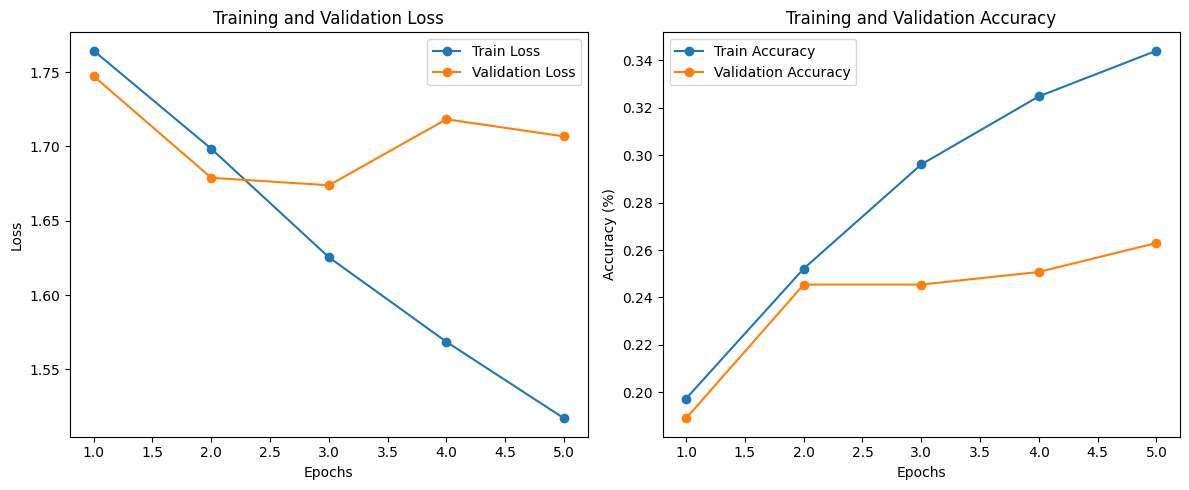

In [ ]:
import matplotlib.pyplot as plt


epochs = [1, 2, 3, 4, 5]

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_l, label='Train Loss', marker='o')
plt.plot(epochs, val_loss_l, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_l, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc_l, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.tight_layout()
plt.show()


TEXT + OUR META DATA

In [ ]:



def preprocess_text(text):
    text = re.sub(r'[^\w\s]', ' ', str(text))
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()


def text_tokenization(text):
    return word_tokenize(text)


def merge_and_clean(dataframe, columns):
    merged_text = dataframe[columns].astype(str).agg(' '.join, axis=1)
    return merged_text.apply(preprocess_text)


selected_columns = [2,3,5,7,13]



train_texts = merge_and_clean(train_df, selected_columns).apply(text_tokenization)
test_texts = merge_and_clean(test_df, selected_columns).apply(text_tokenization)
val_texts = merge_and_clean(val_df, selected_columns).apply(text_tokenization)


total_tokens = [token for text in train_texts for token in text] + \
               [token for text in test_texts for token in text] + \
               [token for text in val_texts for token in text]
word_counts = Counter(total_tokens)
vocab_length = len(word_counts)


word_indices = {word: idx + 1 for idx, word in enumerate(word_counts)}


def convert_tokens_to_indices(token_lists):
    return [[word_indices.get(token, 0) for token in tokens] for tokens in token_lists],True

train_idx,status1 = convert_tokens_to_indices(train_texts)
if status1:
    word_s1=True
test_idx,status2 = convert_tokens_to_indices(test_texts)
if status2:
    word_s2=True
val_idx,status3 = convert_tokens_to_indices(val_texts)
if status3:
    word_s3=True


def sequence_padding(sequences, max_length):
    sequence_padded = pad_sequence([torch.tensor(sequence) for sequence in sequences],
                                   batch_first=True, padding_value=0)
    return True,sequence_padded[:, :max_length]
def find_max_sequence_length(sequences):

    try:
        max_length = max(len(sequence) for sequence in sequences)
        return True, max_length
    except Exception as e:
        print(f"Error in find_max_sequence_length: {e}")
        return False, 0

max_length = max(len(s) for seq in [train_idx, test_idx, val_idx] for s in seq)


train_cond,X_train_padded = sequence_padding(train_idx, max_length)
if train_cond!=True:
    print("Exception")
test_cond,X_test_padded = sequence_padding(test_idx, max_length)
if test_cond!=True:
    print("Exception")
val_cond,X_val_padded = sequence_padding(val_idx, max_length)
if val_cond!=True:
    print("Exception")



def map_labels_to_tensors(dataframe, column_index, label_mapping):

    try:
        mapped_labels = dataframe[column_index].map(label_mapping)
        return torch.tensor(mapped_labels.values, dtype=torch.float)
    except Exception as e:
        print(f"Error during label mapping and tensor conversion: {e}")
        return None





y_train = map_labels_to_tensors(train_df, 1, label_mapping)
y_test = map_labels_to_tensors(test_df, 1, label_mapping)
y_val = map_labels_to_tensors(val_df, 1, label_mapping)


if y_train is not None and y_test is not None and y_val is not None:
    print("Labels successfully mapped to tensors.")
else:
    print("An error occurred during label mapping.")


assert X_train_padded.size(0) == y_train.size(0), "Inconsistent data lengths for training set"


batch_size = 32


train_dataset = TensorDataset(X_train_padded, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_padded, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = TensorDataset(X_test_padded, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


Labels successfully mapped to tensors.


In [ ]:
import torch
import torch.optim as optim


vocab_size = len(word_indices) + 1

embedding_dim = 100
n_filters = 100

filter_sizes = [2, 3, 4]
lstm_hidden_dim = 256
output_dim = 6
dropout = 0.5
model = CNNBiLSTMModel(vocab_size, embedding_dim, n_filters, filter_sizes, lstm_hidden_dim, output_dim, dropout)
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
train_loss_l=[]
val_loss_l=[]
train_acc_l=[]
val_acc_l=[]

In [ ]:

n_epochs = 5
for epoch in range(n_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion)
    train_loss_l.append(train_loss)
    val_loss_l.append(valid_loss)
    train_acc_l.append(train_acc)
    val_acc_l.append(valid_acc)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01
	Train Loss: 1.767 | Train Acc: 19.92%
	 Val. Loss: 1.754 |  Val. Acc: 19.59%
Epoch: 02
	Train Loss: 1.742 | Train Acc: 22.08%
	 Val. Loss: 1.748 |  Val. Acc: 20.05%
Epoch: 03
	Train Loss: 1.724 | Train Acc: 23.21%
	 Val. Loss: 1.704 |  Val. Acc: 26.52%
Epoch: 04
	Train Loss: 1.696 | Train Acc: 24.29%
	 Val. Loss: 1.705 |  Val. Acc: 25.53%
Epoch: 05
	Train Loss: 1.670 | Train Acc: 25.63%
	 Val. Loss: 1.675 |  Val. Acc: 28.05%


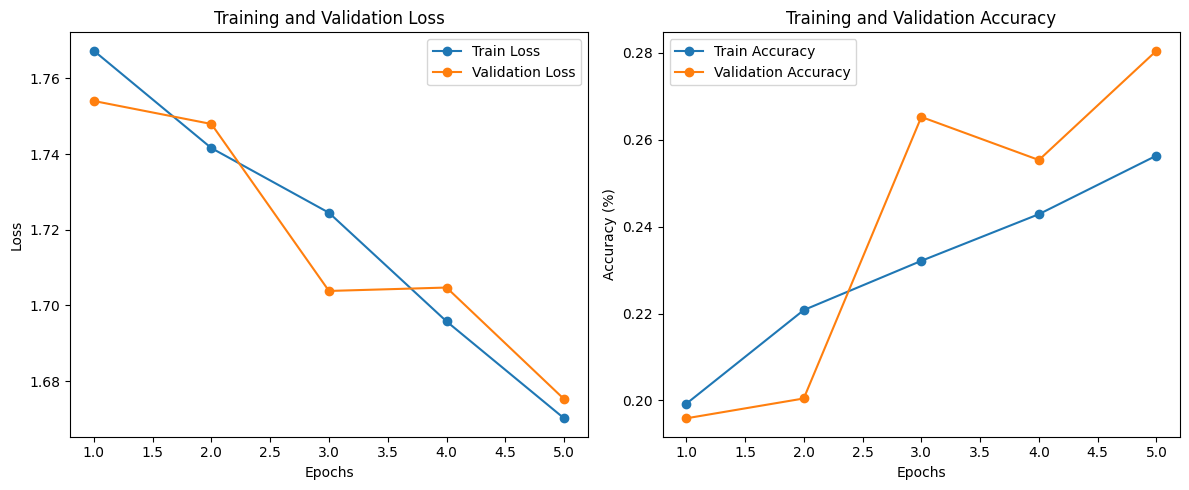

In [ ]:
import matplotlib.pyplot as plt


epochs = [1, 2, 3, 4, 5]

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_l, label='Train Loss', marker='o')
plt.plot(epochs, val_loss_l, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_l, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc_l, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.tight_layout()
plt.show()


In [ ]:

test_loss, test_acc = evaluate(model, test_loader, criterion)


print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')


Test Loss: 1.691 | Test Acc: 26.44%
